[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D2_GoodResearchPractices/W2D2_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D2_GoodResearchPractices/W2D2_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 6: Implementing the Analysis**

**Good Research Practices**

**Content creators:** Marguerite Brown, Yuxin Zhou

**Content reviewers:** Sherry Mi, Maria Gonzalez, Nahid Hasan, Beatriz Cosenza Muralles, Katrina Dobson, Sloane Garelick, Cheng Zhang

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorials Objectives**

In Tutorials 5-8, you will learn about the research process. This includes how to

5.   Draft analyses of data to test a hypothesis
6.   Implement analysis of data
7.   Interpret results in the context of existing knowledge
8.   Communicate your results and conclusions

By the end of these tutorials you will be able to:

*   Understand the principles of good research practices
*   Learn to view a scientific data set or question through the lens of equity: Who is represented by this data and who is not? Who has access to this information? Who is in a position to use it?


# **Activity: Implement the Analysis**

In this tutorial, you will be implementing a linear regression model as outlined in Step 5 on real-world CO<sub>2</sub> and temperature records.

The CO<sub>2</sub> and temperature records we will be analyzing are both examples of paleoclimate data (for more information, refer back to Step 3). The CO<sub>2</sub> record (Bereiter et al., 2015) was generated by measuring the CO<sub>2</sub> concentration in ancient air bubbles trapped inside ice from multiple ice cores retrieved from Antarctica. The temperature record (Shakun et al., 2015) is based on chemical analysis done on the shells of planktic foraminifera. The foraminifera shells were identified and picked from deep-sea sediments, and the temperature record combined multiple sea-surface temperature records from a range of sites globally.

Why are we focusing on these two records specifically? The CO<sub>2</sub> record from Antarctic ice core is the gold standard of air CO<sub>2</sub> variability on glacial-interglacial time scales, and it has a temporal resolution unmatched by any other reconstruction methods. The temperature record comes from sediment cores all over the global ocean, and therefore is likely representative of the global surface ocean temperature variability. Polar air temperature records are also available from ice core studies, but such records may represent an exaggerated view of the global temperature because of polar amplification.

If you would like to learn more, the data sources are listed at the bottom of the page.



In [1]:
# imports

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import interpolate
from scipy import stats
import os
import pooch
import tempfile

In [2]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [3]:
# time series
# read SST data "Shakun2015_SST.txt"
filename_Shakun2015_SST='Shakun2015_SST.txt'
url_Shakun2015_SST = "https://osf.io/kmy5w/download"
SST = pd.read_table(pooch_load(url_Shakun2015_SST,filename_Shakun2015_SST))
SST.set_index('Age', inplace=True)
SST

,SST stack,_18Op stack,_18Ob stack,_18Osw stack,_18Osw uncertainty (2_),Deep ocean temperature,Detrended sea-level equivalent,Sea level uncertainty (2_),Unnamed: 9,Unnamed: 10
Age,,,,,,,,,,
3,1.2,-0.81,-0.88,-0.58,0.11,0.0,0,14,NaN,NaN
6,1.3,-0.76,-0.87,-0.50,0.11,0.1,-10,14,NaN,NaN
9,1.4,-0.57,-0.62,-0.28,0.11,0.5,-38,14,NaN,NaN
12,1.0,-0.16,-0.23,0.06,0.09,0.1,-80,12,NaN,NaN
15,0.1,0.31,0.27,0.33,0.09,-1.4,-115,12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
786,0.3,-0.10,-0.34,-0.14,0.22,0.1,-50,28,NaN,NaN
789,-0.1,0.03,-0.21,0.09,0.29,0.0,-79,36,NaN,NaN
792,-0.3,0.40,0.26,0.30,0.23,-0.8,-106,30,NaN,NaN


In [4]:
# read CO2 dataantarctica2015co2composite_cleaned.txt
filename_antarctica2015co2composite_cleaned='antarctica2015co2composite_cleaned.txt'
url_antarctica2015co2composite_cleaned = "https://osf.io/45fev/download"
CO2 = pd.read_table(pooch_load(url_antarctica2015co2composite_cleaned,filename_antarctica2015co2composite_cleaned))
CO2.set_index('age_gas_calBP', inplace=True)
CO2

,co2_ppm,co2_1s_ppm
age_gas_calBP,,
-51.03,368.02,0.06
-48.00,361.78,0.37
-46.28,359.65,0.10
-44.41,357.11,0.16
-43.08,353.95,0.04
...,...,...
803925.28,202.92,2.06
804009.87,207.50,0.92
804522.67,204.86,1.64


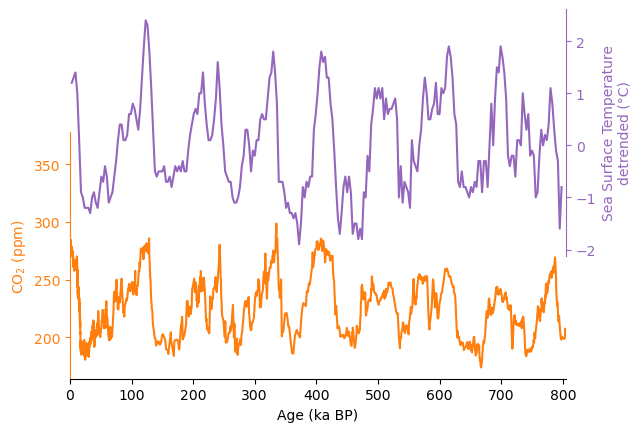

In [5]:
# plot
# set up two subplots in a grid of 2 rows and 1 column
# also make sure the two plots share the same x(time) axis
fig, axes = plt.subplots(2, 1, sharex=True)
# move the two subplots closer to each other
fig.subplots_adjust(hspace=-0.5)
axes[0].plot(SST.index, SST['SST stack'], color='C4')
axes[1].plot(CO2.index/1000, CO2['co2_ppm'], color='C1')

# beautification
# since sharex=True in plt.subplots(), this sets the x axis limit for both panels
axes[1].set_xlim((0, 805))
# axis labels
axes[1].set_xlabel('Age (ka BP)')
axes[0].set_ylabel(r'Sea Surface Temperature'
                   '\n'
                   'detrended (°C)',
                   color='C4')
axes[1].set_ylabel(r'CO${}_\mathrm{2}$ (ppm)',
                   color='C1')

# despine makes the plots look cleaner
sns.despine(ax=axes[0], top=True, right=False, bottom=True, left=True)
sns.despine(ax=axes[1], top=True, right=True, bottom=False, left=False)
# clean up top panel x axis ticks
axes[0].xaxis.set_ticks_position('none')
# move top panel xlabel to the right side
axes[0].yaxis.set_label_position('right')
# the following code ensures the subplots don't overlap
for ax in axes:
    ax.set_zorder(10)
    ax.set_facecolor('none')
# color the axis
axes[0].spines['right'].set_color('C4')
axes[1].spines['left'].set_color('C1')
axes[0].tick_params(axis='y', colors='C4')
axes[1].tick_params(axis='y', colors='C1')

Now that we've taken a look at the two time series, let's make a scatter plot between them and fit a linear regression model through the data.

pearson (r^2) value: 0.55 
with a p-value of: 3.37e-47


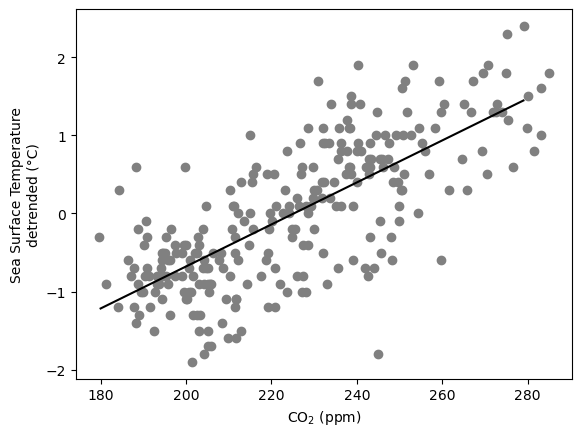

In [6]:
# in this code block, we will make a scatter plot of CO2 and temperature
# and fit a linear regression model through the data

def age_model_interp(CO2_age, CO2, SST_age):
    '''
    This helper function linearly interpolates CO2 data, which
    have a very high temporal resolution, to temperature data,
    which have a relatively low resolution
    '''
    f = interpolate.interp1d(CO2_age, CO2)
    all_ages = f(SST_age)
    return all_ages

# interpolate CO2 data to SST age
CO2_interpolated = age_model_interp(CO2.index/1000, CO2['co2_ppm'], SST.index)

# plot
# set up two subplots in a grid of 2 rows and 1 column
# also make sure the two plots share the same x(time) axis
fig, ax = plt.subplots(1, 1, sharex=True)

ax.scatter(CO2_interpolated, SST['SST stack'], color='gray')

# regression
X = CO2_interpolated
y = SST['SST stack']
res = stats.linregress(X,y)    # ordinary least sqaure

x_fit = np.arange(180, 280)
# intercept
y_fit = x_fit * res.slope +res.intercept
ax.plot(x_fit, y_fit, color='k')

# beautification
# axis labels
ax.set_xlabel(r'CO${}_\mathrm{2}$ (ppm)')
ax.set_ylabel(r'Sea Surface Temperature'
                    '\n'
                    'detrended (°C)')
print('pearson (r^2) value: ' +'{:.2f}'.format(res.rvalue**2)+' \nwith a p-value of: '+'{:.2e}'.format(res.pvalue))

## **Figure Making Through the Equity Lense**
<details>
<summary>Click here for some information</summary>
Are the colors in your figure distinguishable for people with color-vision deficiencies?

More readings on this topic:

Contrast checker: https://www.color-blindness.com/coblis-color-blindness-simulator/

Coloring for color blindness: https://davidmathlogic.com/colorblind

Python-specific color palettes that are friendly to those with color-vision deficiency: https://seaborn.pydata.org/tutorial/color_palettes.html

# **Resources**

Data from the following sources are used in this tutorial:

CO<sub>2</sub>: Bereiter, B., Eggleston, S., Schmitt, J., Nehrbass-Ahles, C., Stocker, T.F., Fischer, H., Kipfstuhl, S., Chappellaz, J., 2015. Revision of the EPICA Dome C CO2 record from 800 to 600 kyr before present. Geophysical Research Letters 42, 542–549. https://doi.org/10.1002/2014GL061957

Temperature: Shakun, J.D., Lea, D.W., Lisiecki, L.E., Raymo, M.E., 2015. An 800-kyr record of global surface ocean δ18O and implications for ice volume-temperature coupling. Earth and Planetary Science Letters 426, 58–68. https://doi.org/10.1016/j.epsl.2015.05.042


